<a href="https://colab.research.google.com/github/XiangxiangXu/NFE/blob/main/MaxCorr_Normal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Maximal Correlation for Normal Distribution.
- Network: MLP with batch-normalization.

Set GPU.

In [1]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [2]:
import torch

In [3]:
import numpy as np


In [4]:
# number of samples
nSamples_train = 50000
nSamples_test = 10000
nSamples = nSamples_train + nSamples_test


## Parameters for Training
# batch size
batchsize = 512

# number of epochs
nEpochs = 400

dim = 5

In [5]:
rho = .8
La = np.array([[1, rho], [rho, 1]])
XY = np.random.multivariate_normal(mean = [0, 0], cov = La, size = nSamples)
X = XY[:, 0]
Y = XY[:, 1]

(array([1.000e+00, 1.400e+01, 2.200e+01, 5.100e+01, 1.040e+02, 2.510e+02,
        4.420e+02, 8.560e+02, 1.441e+03, 2.291e+03, 3.188e+03, 4.319e+03,
        5.447e+03, 6.148e+03, 6.534e+03, 6.498e+03, 6.025e+03, 5.032e+03,
        4.022e+03, 2.924e+03, 1.841e+03, 1.196e+03, 6.560e+02, 3.490e+02,
        2.060e+02, 8.900e+01, 3.900e+01, 1.000e+01, 2.000e+00, 2.000e+00]),
 array([-4.11336229, -3.83588305, -3.5584038 , -3.28092456, -3.00344531,
        -2.72596607, -2.44848682, -2.17100758, -1.89352833, -1.61604909,
        -1.33856984, -1.06109059, -0.78361135, -0.5061321 , -0.22865286,
         0.04882639,  0.32630563,  0.60378488,  0.88126412,  1.15874337,
         1.43622261,  1.71370186,  1.9911811 ,  2.26866035,  2.54613959,
         2.82361884,  3.10109808,  3.37857733,  3.65605657,  3.93353582,
         4.21101506]),
 <BarContainer object of 30 artists>)

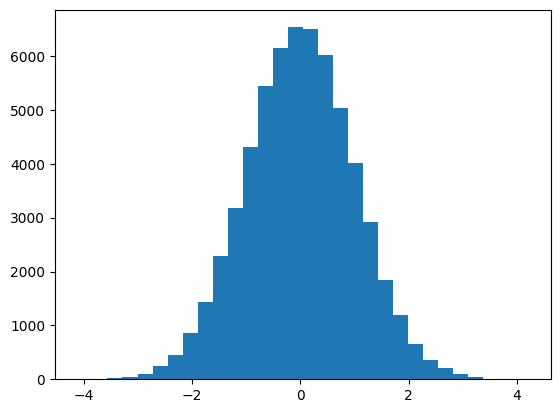

In [6]:
from matplotlib import pyplot as plt
plt.hist(X, 30)

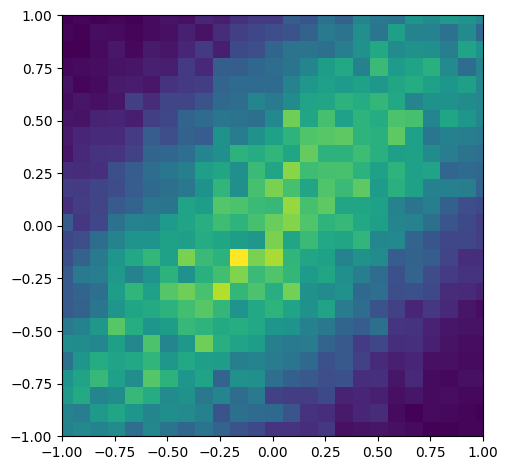

In [7]:
plt.hist2d(X, Y, 100)

plt.tight_layout()
plt.axis([-1, 1, -1, 1])
plt.gca().set_aspect('equal', adjustable='box')#plt.axis('equal')

In [8]:
from torch.utils.data import TensorDataset, DataLoader
Xt = torch.tensor(X, dtype=torch.float32)
Yt = torch.tensor(Y, dtype=torch.float32)
# dataloder for training
Xt_train = Xt[:nSamples_train]
Yt_train = Yt[:nSamples_train]

ds = TensorDataset(Xt_train, Yt_train)
dl = DataLoader(ds, batch_size=batchsize, shuffle = True)

# test data
X_test = X[nSamples_train:]
Y_test = Y[nSamples_train:]

Xt_test = Xt[nSamples_train:]
Yt_test = Yt[nSamples_train:]

In [9]:
from torch import nn, optim
import torch.nn.functional as F
class mlp(nn.Module):
    def __init__(self, dim_list, activation = F.relu):
        super().__init__()
        self.fc_list = nn.ModuleList([nn.Linear(dim_list[i], dim_list[i+1]) for i in range(len(dim_list) - 1)])
        self.bn_list = nn.ModuleList([nn.BatchNorm1d(dim_list[i]) for i in range(len(dim_list) - 1)])
        self.activation = activation

    def forward(self, x):
        num_layers = len(self.fc_list)
        for i in range(num_layers):
            x = self.bn_list[i](x)
            x = self.fc_list[i](x)
            if i != num_layers - 1: # activate except for the last layer
                x = self.activation(x)
        return x

class mlp_parallel(nn.Module):
    def __init__(self, dim_list, m = 1, activation = F.relu):
        super().__init__()
        self.mlp_list = nn.ModuleList([mlp(dim_list, activation) for i in range(m)])

    def forward(self, x):
        f = torch.cat([mlp_(x) for mlp_ in self.mlp_list], axis = -1)
        return f

class fg_nn(nn.Module): # f_net, g_net
    def __init__(self, f_net, g_net):
        super().__init__()
        self.f_net = f_net
        self.g_net = g_net

    def forward(self, x, y):
        f = self.f_net(x)
        g = self.g_net(y)
        return f, g

    def get_f(self, x):
        f = self.f_net(x)
        return f

    def get_g(self, y):
        g = self.g_net(y)
        return g


f_net = mlp([1, 64, 128, dim], activation = F.softplus) #  mlp_parallel([1, 32, 32, 1], m = dim, activation = F.softplus) #
g_net =  mlp([1, 64, 128, dim], activation = F.softplus) #  #mlp_parallel([1, 32, 32, 1], m = dim, activation = F.softplus) #

model = fg_nn(f_net, g_net)
# model.to(device)
opt = optim.Adam(model.parameters()) # optim.RMSprop(model.parameters(), lr = 1e-3) # or Adam

In [10]:
centralize = lambda x: x - torch.mean(x, 0) # zero-mean
cov = lambda x: x.T @ x / (x.size()[0]-1.) # covariance

def neg_hscore(f, g):
    """
    compute the negative h-score
    """
    f0 = centralize(f)
    g0 = centralize(g)
    corr = torch.mean(torch.sum(f0*g0, 1))
    # to generate zero-mean f, g
    cov_f = cov(f)
    cov_g = cov(g)
    return - corr + torch.trace(cov_f @ cov_g) / 2.

def stop_grad(x):
    # return deatched x (except the last dim)
    return torch.cat((x[:, :-1].detach(), x[:, [-1]]), axis = -1)


def neg_hscore_nest(f, g, dim0 = 0):
    """
    compute the (negative) nested H-score:

    from dim0
    """
    f_dim = f.shape[1]
    neg_h_nest = torch.sum(torch.stack(
        [neg_hscore(stop_grad(f[:, :i+1]), stop_grad(g[:, :i+1])) # stop_grad
         for i in range(dim0, f_dim)]))
    return neg_h_nest

In [11]:
for epoch in range(nEpochs):
    for x, y in dl:
        f_, g_ = model(x.reshape(-1, 1), y.reshape(-1, 1))
        loss = neg_hscore_nest(f_, g_)
        loss.backward()
        opt.step()
        opt.zero_grad()
    if epoch % 10 == 0:
        print('epoch:', epoch, '/', nEpochs)# 'training neg_h_score =', loss)


epoch: 0 / 400
epoch: 10 / 400
epoch: 20 / 400
epoch: 30 / 400
epoch: 40 / 400
epoch: 50 / 400
epoch: 60 / 400
epoch: 70 / 400
epoch: 80 / 400
epoch: 90 / 400
epoch: 100 / 400
epoch: 110 / 400
epoch: 120 / 400
epoch: 130 / 400
epoch: 140 / 400
epoch: 150 / 400
epoch: 160 / 400
epoch: 170 / 400
epoch: 180 / 400
epoch: 190 / 400
epoch: 200 / 400
epoch: 210 / 400
epoch: 220 / 400
epoch: 230 / 400
epoch: 240 / 400
epoch: 250 / 400
epoch: 260 / 400
epoch: 270 / 400
epoch: 280 / 400
epoch: 290 / 400
epoch: 300 / 400
epoch: 310 / 400
epoch: 320 / 400
epoch: 330 / 400
epoch: 340 / 400
epoch: 350 / 400
epoch: 360 / 400
epoch: 370 / 400
epoch: 380 / 400
epoch: 390 / 400


In [12]:
detach = lambda x: x.cpu().detach().numpy()
norm = lambda x: np.sqrt(np.mean(x**2))

# get features on the training set
f_train = detach(model.get_f(Xt_train.reshape(-1, 1)))
g_train = detach(model.get_g(Yt_train.reshape(-1, 1)))

# compute norm for each dimension
norm_f = np.zeros(dim)
norm_g = np.zeros(dim)
#mu_f = np.zeros(dim)
#mu_g = np.zeros(dim)
for i in range(dim):
    #mu_f[i] = np.mean(f_train[:, i])
    norm_f[i] = norm(f_train[:, i])
    #mu_g[i] = np.mean(g_test[:, i])
    norm_g[i] = norm(g_train[:, i])

Xt_grid = torch.linspace(-1, 1, steps=1000).reshape(-1, 1)
X_grid = detach(Xt_grid).reshape(-1)
Yt_grid = Xt_grid
Y_grid = X_grid

# evaluate model:
model.eval()

with torch.no_grad():
    f_grid = detach(model.get_f(Xt_grid))
    g_grid = detach(model.get_g(Yt_grid))





In [13]:
#  https://en.wikipedia.org/wiki/Mehler_kernel#Probability_version
from scipy import special

def scaled_hermite_prob(n):
    # n-th order probabilist's Hermite polynomials, scaled by 1/sqrt(n!)
    hermite = special.hermitenorm(n, monic=True)
    func = lambda x: hermite(x)/np.sqrt(special.factorial(n))
    return func


In [14]:
sign_ip = lambda v1, v2: np.sign(np.sum(v1.squeeze() * v2.squeeze()))

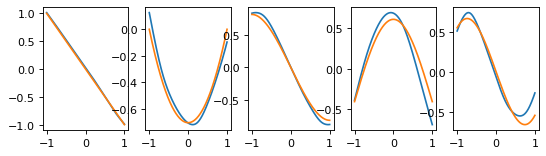

In [15]:
plt.figure(figsize=(8, 2), dpi=80)
# normalize ...
for i in range(dim):
    f_gt = scaled_hermite_prob(i+1)
    plt.subplot(1, dim, i+1)
    plt.plot(X_grid, f_grid[:, i]/norm_f[i])
    sign = sign_ip(f_grid[:, i], f_gt(X_grid))
    # aovid sign flipping for plotting
    plt.plot(X_grid, f_gt(X_grid) * sign)



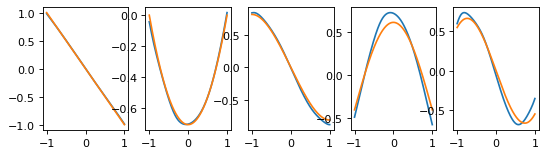

In [16]:
plt.figure(figsize=(8, 2), dpi=80)
# normalize ...
for i in range(dim):
    plt.subplot(1, dim, i+1)
    plt.plot(Y_grid, g_grid[:, i]/norm_g[i])
    g_gt = scaled_hermite_prob(i+1)
    sign = sign_ip(g_grid[:, i], g_gt(X_grid))
    # aovid sign flipping for plotting
    plt.plot(Y_grid, g_gt(Y_grid) * sign)

In [17]:
# get features on the testing set
with torch.no_grad():
    f_test = model.get_f(Xt_test.reshape(-1, 1)).detach().numpy()
    g_test = model.get_g(Yt_test.reshape(-1, 1)).detach().numpy()

# # compute stand deviations for each dimension
# std_f = np.zeros(dim)
# std_g = np.zeros(dim)
# mu_f = np.zeros(dim)
# mu_g = np.zeros(dim)
# for i in range(dim):
#     mu_f[i] = np.mean(f_test[:, i])
#     std_f[i] = np.std(f_test[:, i])
#     mu_g[i] = np.mean(g_test[:, i])
#     std_g[i] = np.std(g_test[:, i])

Compute Correlation

In [18]:
# compute the correlation coefficients between x, y
corr = lambda x, y: (np.corrcoef(x.reshape(-1), y.reshape(-1)))[0, 1]


print('corr(x, y) =', corr(X, Y))




corr(x, y) = 0.7973409309438698


Correlation between different modes

In [19]:
corr_list = [corr(f_test[:, i], g_test[:, i]) for i in range(dim)]
for i in range(dim):
    print('corr(f' + str(i+1) + '(x), g' + str(i+1) + '(x)) =', corr_list[i])

corr(f1(x), g1(x)) = 0.7935676830541819
corr(f2(x), g2(x)) = 0.6237985268560717
corr(f3(x), g3(x)) = 0.5102926028730663
corr(f4(x), g4(x)) = 0.43799865703001895
corr(f5(x), g5(x)) = 0.3300473112420341


Ground Truth

In [20]:
corr_list_gt = [rho ** i for i in range(1, dim+1)]

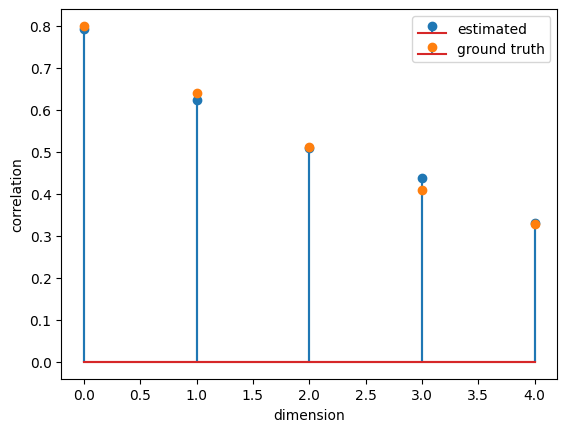

In [21]:
plt.stem(corr_list, '*', label='estimated')
plt.stem(corr_list_gt, '*', label='ground truth')
plt.xlabel('dimension')
plt.ylabel('correlation')
plt.legend()
plt.show()

Check uncorrelatedness

In [22]:
# uncorrelatedness
print('corr(f1(x), f2(x)) =', corr(f_test[:, 0], f_test[:, 1]))
print('corr(f1(x), g2(y)) =', corr(f_test[:, 0], g_test[:, 1]))

corr(f1(x), f2(x)) = 0.02530142249986267
corr(f1(x), g2(y)) = -0.07317330231707138
